# Base CNN
Dies ist das Jupyer-Notebook für die Erstellung und das Tuning der Basis-Architektur. Mit diesem Notebook kann ein CNN entweder für eine Binäre oder Multi-Label Klassifikation erstellt werden. Dazu können die beiden Datensätze verwendet werden, welche wir bereitgestellt haben. Theoretisch könnten diese auch verbunden werden, was wir aber nicht gemacht haben.

# Importierung

Für die bessere Überischt importieren wir alles an einem Ort. Wir verwenden hier Keras V3. Damit wird ermöglicht, dass wir Backend-Agnostic arbeiten können. Das bedeutet, dass wir das Backend (Tensorflow, Pytorch, Jax) einfach wechseln können.
Wir verwenden hier Pytorch als Backend, da es nativen GPU Support auf Windows hat. Ohne GPU geht das Training viel zu lange.

In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers
from matplotlib import pyplot as plt
import keras_tuner

# Recommended to leave default values
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

# Customizable values
BATCH_SIZE = 64
AUGMENT = True  # If the images should be augmented
TUNE = False  # If the model architecture should be tuned

# Hunde-Vögel Bild-Datensatz laden

Mit der Funktion `image_dataset_from_directory` können wir die Bilddaten von der Festplatte laden. Dabei müssen sie in einem bestimmten Format sein. Ein Ordner mit jeweils einem Unterordner für jede Klasse. Hier werden auch direkt die Batches erstellt, die Bilder auf eine gemeinsame Grösse "gepadded" und ein Validation/Train Split erstellt. Die Labels sind für zwei Klassen Binär (0 oder 1) und bei mehreren Klassen als One-Hot-Encoded Vektor gespeichert.

Für das initiale Training wird nur ein Datensatz mit Bildern von Hünden und Vögeln verwendet.

Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Using 4000 files for validation.
tf.Tensor(
[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]], shape=(64, 1), dtype=float32)


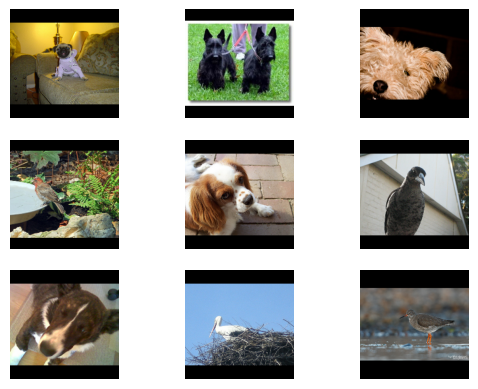

<Figure size 2000x2000 with 0 Axes>

In [2]:
_data_dir = os.path.join("data", "dog_bird", "images")
_entries = os.listdir(_data_dir)
_folder_count = sum(os.path.isdir(os.path.join(_data_dir, entry)) for entry in _entries)

TRAIN_DS, VAL_DS = keras.utils.image_dataset_from_directory(
    _data_dir,
    labels="inferred",
    label_mode="binary" if _folder_count == 2 else "categorical",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    interpolation="bilinear",
    pad_to_aspect_ratio=True,
    validation_split=0.2,
    subset="both",
    seed=42,
)


if len(TRAIN_DS.class_names) == 2:
    NUMBER_OF_CLASSES = 1
else:
    NUMBER_OF_CLASSES = len(TRAIN_DS.class_names)

for _, _labels in TRAIN_DS.take(1):
    print(_labels)
    break

for batch_images, _ in TRAIN_DS.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(keras.utils.array_to_img(batch_images[i]))
        plt.axis("off")
plt.figure(figsize=(20, 20))
plt.show()

# Basis-Architektur für CNN

Dann bauen wir ein Basis-CNN. Der Kern sind 4 Gruppen an Layers, welche jeweils eine Convolution, Batch-Normalisierung, Max-Pooling und Dropout beinhalten. Dabei vergrössert sich die Filter-Grösse in jedem Schritt. Dadurch erhoffen wir uns zuerst kleinere Features zu finden und dann grössere Zusammenhänge in den Bildern abzudecken.

Als Metriken verwenden wir die Precision, Recall, F1-Score und Accuracy. Die Loss-Funktion ist je nach Anzahl Klassen entweder BinaryCrossentropy oder CategoricalCrossentropy. Den Loss Berechnen wir jeweils direkt von den Logits, weil es sonst Probleme mit Pytorch gab. Es gab Probleme, wenn wir zuerst ein Klassifikationslayer verwendeten. Als Optimizer verwenden wir AdamW.

# Data Augmentation

Data Augmentation hilft dabei helfen die Klassifikation besser zu machen, indem die Daten variiert werden. Damit sollte das Modell weniger von Overfitting betroffen sein. Wir drehen sie, verändern den Kontrast und die Helligkeit.

In [3]:
# TODO Visualisierung der Daten (Jorma)
# TODO Visualisierung der Validation (Nico)
# TODO Bericht (Jorma)


def build_cnn_model(
    hp,
    tune_inter_regularization=True,
    tune_output_regularization=True,
    tune_convolutions=False,
    tune_lr=False,
    tune_dens_layers=False,
):

    _METRICS = [
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.F1Score(name="f1"),
        keras.metrics.BinaryAccuracy(name="accuracy") if NUMBER_OF_CLASSES == 1 else keras.metrics.CategoricalAccuracy(name="accuracy")
    ]

    # Tuning setup
    inter_dropout = (
        hp.Boolean("inter_dropout") if (TUNE and tune_inter_regularization) else False
    )
    inter_batch_norm = (
        hp.Boolean("inter_batch_norm") if (TUNE and tune_inter_regularization) else True
    )

    output_dropout = (
        hp.Boolean("output_dropout") if (TUNE and tune_output_regularization) else False
    )
    output_batch_norm = (
        hp.Boolean("output_batch_norm")
        if (TUNE and tune_output_regularization)
        else True
    )

    filter_size = (
        hp.Choice("filter_size", [8, 16, 32, 64]) if (TUNE and tune_convolutions) else 8
    )
    pool_type = (
        hp.Choice("pool_type", ["max", "avg"])
        if (TUNE and tune_convolutions)
        else "max"
    )

    learning_rate = (
        hp.Choice("learning_rate", [0.001, 0.0001, 0.00001])
        if (TUNE and tune_lr)
        else 0.001
    )

    dense_layer_amount = (
        hp.Choice("dense_layer_amount", [1, 2, 3]) if (TUNE and tune_dens_layers) else 3
    )
    dense_layer_base = (
        hp.Choice("dense_layer_base", [64, 128, 256])
        if (TUNE and tune_dens_layers)
        else 64
    )

    # Input layers
    _keras_model = keras.Sequential()
    _keras_model.add(layers.InputLayer(shape=INPUT_SHAPE, name="input"))
    if AUGMENT:
        _keras_model.add(layers.RandomContrast(0.4))
        _keras_model.add(layers.RandomBrightness(0.4))
        # _keras_model.add(layers.RandomRotation(0.4))  ignored because performance was bad

    _keras_model.add(layers.Rescaling(1.0 / 255))

    # Intermediate architecture
    for size in [filter_size, filter_size * 2, filter_size * 4, filter_size * 8]:
        _keras_model.add(
            layers.Conv2D(
                size, kernel_size=(3, 3), activation="relu", name=f"conv_{size}"
            )
        )
        if inter_batch_norm:
            _keras_model.add(layers.BatchNormalization(name=f"batch_norm_{size}"))
        if pool_type == "max":
            _keras_model.add(
                layers.MaxPooling2D(pool_size=(2, 2), name=f"max_pool_{size}")
            )
        else:
            _keras_model.add(
                layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_{size}")
            )
        if inter_dropout:
            _keras_model.add(layers.Dropout(0.2, name=f"dropout_{size}"))

    # Final layers
    if pool_type == "max":
        _keras_model.add(layers.GlobalMaxPooling2D(name="global_max_pool"))
    else:
        _keras_model.add(layers.GlobalAveragePooling2D(name="global_avg_pool"))
        
    _keras_model.add(layers.Flatten(name="flatten"))

    if dense_layer_amount == 1:
        _keras_model.add(
            layers.Dense(dense_layer_base, activation="relu", name="dense_1")
        )
    elif dense_layer_amount == 2:
        _keras_model.add(
            layers.Dense(dense_layer_base, activation="relu", name="dense_1")
        )
        _keras_model.add(
            layers.Dense(dense_layer_base * 2, activation="relu", name="dense_2")
        )
    elif dense_layer_amount == 3:
        _keras_model.add(
            layers.Dense(dense_layer_base, activation="relu", name="dense_1")
        )
        _keras_model.add(
            layers.Dense(dense_layer_base * 2, activation="relu", name="dense_2")
        )
        _keras_model.add(
            layers.Dense(dense_layer_base * 4, activation="relu", name="dense_3")
        )

    if output_batch_norm:
        _keras_model.add(layers.BatchNormalization(name="batch_norm__keras_model"))
    if output_dropout:
        _keras_model.add(layers.Dropout(0.2))
    _keras_model.add(
        layers.Dense(NUMBER_OF_CLASSES, activation=None, name="dense__keras_model")
    )

    # Compile
    if NUMBER_OF_CLASSES == 1:
        _keras_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=_METRICS,
        )
    else:
        _keras_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=_METRICS,
    )
    return _keras_model

# Tuning
Die gewählte Basis-Architektur wurde anschliessend durch Tuning verbessert. Es wurden insgesamt 3 Tuning-Durchläufe umgesetzt:
- Regularisierung: Dropout und Batch-Normalisierung wurden getunt.
- Convolutions und Learning-Rate: Die Anzahl der Filter, der Pooling-Typ und die Learning-Rate wurden getunt.
- Dense Layers: Die Anzahl und Grösse der Dense Layers wurde getunt.

# Training nach Tuning der Basis-Architektur

Das Modell wird über mehrere Wochen hinweg trainiert. Dabei verwenden wir mehrere Techniken:
- Early Stopping: Wenn die Validation Accuracy nicht mehr steigt, wird das Training abgebrochen. Damit verhindern wir ein Overfitting auch die Trainingsdaten.
- Model Checkpointing: Das beste Modell wird gespeichert jeder Epoche gespeichert. Praktisch, wenn das Training abgebrochen wird.
- Learning Rate Scheduler: Die Learning Rate wird reduziert, wenn die Validation Accuracy nicht mehr steigt.



In [4]:
if TUNE:
    tuner = keras_tuner.RandomSearch(
        hypermodel=build_cnn_model,
        objective="val_accuracy",
        max_trials=20,
        overwrite=False,
        directory="tuning",
        project_name="tuning",
    )
    tuner.search_space_summary()
    tuner.search(TRAIN_DS, epochs=4, validation_data=VAL_DS)
    base_model = tuner.get_best_models(num_models=1)[0]
    tuner.results_summary(num_trials=5)
    base_model.summary()
    try:
        keras.utils.plot_model(base_model, show_shapes=True)
    except Exception as e:
        print("Could not plot model", e)
else:
    base_model = build_cnn_model(None)
    base_model.summary()
    try:
        keras.utils.plot_model(base_model, show_shapes=True)
    except Exception as e:
        print("Could not plot model", e)


early_stop_cb = keras.callbacks.EarlyStopping(
    min_delta=0.015,
    monitor="val_accuracy",
    mode="max",
    patience=8,
    restore_best_weights=True,
    verbose=1,
)
checkpointing_cb = keras.callbacks.ModelCheckpoint(
    "bird_dog_classifier.keras" if NUMBER_OF_CLASSES == 1 else "fish_lizard_monkey_snake_transfered_classifier.keras",
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq="epoch",
    initial_value_threshold=None,
)
lr_cb = keras.callbacks.ReduceLROnPlateau(
    min_delta=0.015,
    monitor="val_accuracy",
    mode="max",
    patience=6,
    factor=0.5,
    min_lr=0.00001,
    verbose=1,
)

base_history = base_model.fit(
    TRAIN_DS,
    validation_data=VAL_DS,
    epochs=50,
    callbacks=[early_stop_cb, checkpointing_cb, lr_cb],
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 224, 224, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_8 (Conv2D)                 │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_8                    │ (None, 222, 222, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_8 (MaxPooling2D)       │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_16 (Conv2D)                │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_16                   │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_16 (MaxPooling2D)      │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_32 (Conv2D)                │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_32                   │ (None, 52, 52, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_32 (MaxPooling2D)      │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_64 (Conv2D)                │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_64                   │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_64 (MaxPooling2D)      │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pool                 │ (None, 64)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm__keras_model         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 71,793 (280.44 KB)

 Trainable params: 71,041 (277.50 KB)

 Non-trainable params: 752 (2.94 KB)

Epoch 1/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6473 - f1: 0.6642 - loss: 0.6220 - precision: 0.7136 - recall: 0.4820
Epoch 1: val_accuracy improved from -inf to 0.55400, saving model to bird_dog_classifier.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.6477 - f1: 0.6642 - loss: 0.6215 - precision: 0.7141 - recall: 0.4826 - val_accuracy: 0.5540 - val_f1: 0.6764 - val_loss: 0.8701 - val_precision: 0.5350 - val_recall: 0.9721 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7566 - f1: 0.6616 - loss: 0.4758 - precision: 0.8164 - recall: 0.6545
Epoch 2: val_accuracy improved from 0.55400 to 0.74275, saving model to bird_dog_classifier.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.7567 - f1: 0.6616 - loss: 0.4757 - precision: 0.8165 - recall: 0.6547 - val_accuracy: 0.7427 - val_f1: 0.6764 - val_loss: 0.4721 - val_precision: 0.9083 - val_recall: 0.5523 - learning_rate: 0.0010
Epoch 3/50
249/250 ━━━━

# Evaluation

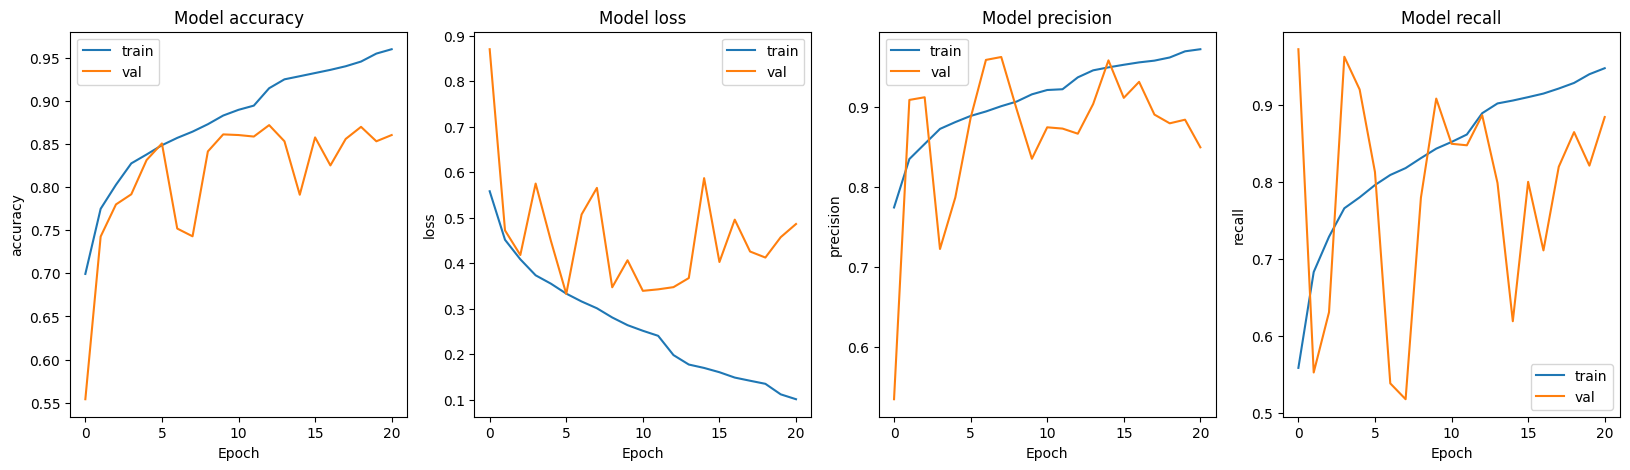

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss", "precision", "recall"]):
    ax[i].plot(base_history.history[metric])
    ax[i].plot(base_history.history["val_" + metric])
    ax[i].set_title(f"Model {metric}")
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# Modell verwenden

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[-6.325357]]
This image is 99.82% bird and 0.18% dog.


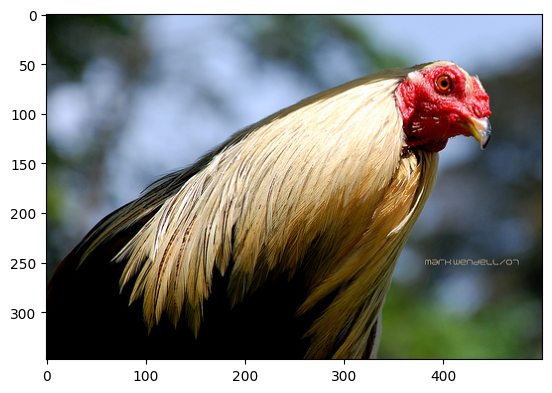

In [6]:
class_names = TRAIN_DS.class_names

img = keras.utils.load_img("data/dog_bird/images/bird/n01514668_3210.JPEG", target_size=IMAGE_SIZE)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # makes a batch out of the one image

predictions = base_model.predict(img_array)
if NUMBER_OF_CLASSES == 1:
    score = float(keras.ops.sigmoid(predictions[0][0]))
    print(f"This image is {100 * (1 - score):.2f}% {class_names[0]} and {100 * score:.2f}% {class_names[1]}.")
else:
    scores = keras.ops.softmax(predictions[0])
    for i, score in enumerate(scores):
        print(f"This image is {100 * score:.2f}% {class_names[i]}.")